# **TASK 3  NLP** Submission by Ajay Agarwal

## Subtask1 -  Cleaning the data
This would involve the following steps --

1. Understanding the data and performing basic EDA
2. Understanding the category tree structure
3. Finding out the maximum and minimum number of sub-categories in category tree
4. Seperating all the sub-categories
5. Finding the primary category

In [1]:

#Let's begin by importing some basic libraries for implementing some basic ML algorithms

import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

Note. Here, we used the parameter of error_bad_lines = False, because in a previous iteration, we encountered the following error -
 
`ParserError: Error tokenizing data. C error: Expected 15 fields in line 19219, saw 23`

This would skip only one line and results in reduction of dataset length by one instance whic doesn't affect the models

In [2]:
#Importing the data as csv file

flipkart_data = pd.read_csv("flipkart_com-ecommerce_sample.csv" , error_bad_lines=False)

In [3]:
flipkart_data.head(15)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."
5,c2a17313954882c1dba461863e98adf2,2016-03-25 22:59:23 +0000,http://www.flipkart.com/eternal-gandhi-super-s...,Eternal Gandhi Super Series Crystal Paper Weig...,"[""Eternal Gandhi Super Series Crystal Paper We...",PWTEB7H2E4KCYUE3,430.0,430.0,"[""http://img5a.flixcart.com/image/paper-weight...",False,Key Features of Eternal Gandhi Super Series Cr...,No rating available,No rating available,Eternal Gandhi,"{""product_specification""=>[{""key""=>""Model Name..."
6,ce5a6818f7707e2cb61fdcdbba61f5ad,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FVVKRBAXHB,1199.0,479.0,"[""http://img6a.flixcart.com/image/short/p/j/z/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
7,8542703ca9e6ebdf6d742638dfb1f2ca,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGYGHFUEXN,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/e/x...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
8,29c8d290caa451f97b1c32df64477a2c,2016-03-25 22:59:23 +0000,http://www.flipkart.com/dilli-bazaaar-bellies-...,"dilli bazaaar Bellies, Corporate Casuals, Casuals","[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH3DZBFR88SCK,699.0,

### Let's understand the category tree in a lexicographical manner.
---



In [4]:
flipkart_data['product_category_tree'].unique()

array(['["Clothing >> Women\'s Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women\'s Cycling Shorts"]',
       '["Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo..."]',
       '["Footwear >> Women\'s Footwear >> Ballerinas >> AW Bellies"]',
       ...,
       '["Baby Care >> Baby & Kids Gifts >> Stickers >> Oren Empower Stickers"]',
       '["Baby Care >> Baby & Kids Gifts >> Stickers >> Uberlyfe Stickers"]',
       '["Baby Care >> Baby & Kids Gifts >> Stickers >> Fun To See Stickers"]'],
      dtype=object)

### Notice - The category tree is made of "each category" followed by the symbol ">>" The first category begins with the symbol [" and the last category ends with the symbol "]

Utilizing this information let's build a function that would find what are the maximum and minimum number of categories possible for any entry in the dataset

In [5]:
#Finding number of sub-categories for each row using the fact that the presence of one symbol ">>" would mean two subcategories present in the category tree

def count_category_remaining():
  count_of_category = []

  for x in range(len(flipkart_data['product_category_tree'])):
   given_tree = flipkart_data.iloc[x]["product_category_tree"]
   count = given_tree.count(">>")
   count_of_category.append(count)
  
#Printing the number of entries for each number of categories.
  from collections import Counter
  c = Counter(count_of_category)
  print(c.most_common())


In [6]:
count_category_remaining()

#This counter can be understood as counting logs out of a woodstick with "n" cuts. So, zero cut means there is one log. Here, zero occurences of >> means that there is one category. 
#Finally, the maximum number of occurence of >> in one row entry is 7, meaning at max there are 8 sub-categories.


[(4, 4910), (3, 4766), (2, 4419), (5, 3640), (1, 1129), (6, 778), (0, 328), (7, 30)]


### Notice, most of the products have either four, three or even two categories. Then, there is suddent drop to five categories products and six category products. The presence of 30 items in eight categories represents a very niched product presence.

## We can say that 
**Number of Categories is directly proportional to degree of product nicheness**

### Established this, we move ahead to seperating each category in the category tree column and adding new columsn in the dataframe for each sub-category encountered while traversing a category from left to right.



In [7]:
#Let's try to seperate the categories in the category tree using lambda functions
#We add columns for each category we seperate in order LtoR

def remove_subcategory():
  n_category=[]
  
  for i in range(len(flipkart_data['product_category_tree'])):
   original = flipkart_data.iloc[i]['product_category_tree']


   
   sub_category = original.partition(">>")
   insert_this = sub_category[0]


   #Removing nth_category from product_category
   old_value = flipkart_data.iloc[i]['product_category_tree']
   new_value = old_value.replace(insert_this+">>","")


   flipkart_data.at[i,"product_category_tree"] = new_value

   if insert_this.startswith("[\""):

    #Appending the nth category to a list of n_category which will be returned
    n_category.append(insert_this.replace("[\"",""))
   else:
     n_category.append(insert_this)

  return n_category


In [8]:
#Since there are maximum eight categories in the product category tree, we create eight new columns and add the sub-category for each respectively

add_category = remove_subcategory()
flipkart_data['first_category'] = add_category

add_category = remove_subcategory()
flipkart_data['second_category'] = add_category

add_category = remove_subcategory()
flipkart_data['third_category'] = add_category

add_category = remove_subcategory()
flipkart_data['fourth_category'] = add_category

add_category = remove_subcategory()
flipkart_data['fifth_category'] = add_category

add_category = remove_subcategory()
flipkart_data['sixth_category'] = add_category

add_category = remove_subcategory()
flipkart_data['seventh_category'] = add_category


add_category = remove_subcategory()
flipkart_data['eigth_category'] = add_category




In [9]:
flipkart_data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,first_category,second_category,third_category,fourth_category,fifth_category,sixth_category,seventh_category,eigth_category
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"Alisha Alisha Solid Women's Cycling Shorts""]",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Women's Clothing,"Lingerie, Sleep & Swimwear",Shorts,"Alisha Alisha Solid Women's Cycling Shorts""]","Alisha Alisha Solid Women's Cycling Shorts""]","Alisha Alisha Solid Women's Cycling Shorts""]","Alisha Alisha Solid Women's Cycling Shorts""]"
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,FabHomeDecor Fabric Double Sofa Bed (Finish C...,SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",Furniture,Living Room Furniture,Sofa Beds & Futons,FabHomeDecor Fabric Double Sofa Bed (Finish C...,FabHomeDecor Fabric Double Sofa Bed (Finish C...,FabHomeDecor Fabric Double Sofa Bed (Finish C...,FabHomeDecor Fabric Double Sofa Bed (Finish C...,FabHomeDecor Fabric Double Sofa Bed (Finish C...
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"AW Bellies""]",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""...",Footwear,Women's Footwear,Ballerinas,"AW Bellies""]","AW Bellies""]","AW Bellies""]","AW Bellies""]","AW Bellies""]"
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"Alisha Alisha Solid Women's Cycling Shorts""]",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Women's Clothing,"Lingerie, Sleep & Swimwear",Shorts,"Alisha Alisha Solid Women's Cycling Shorts""]","Alisha Alisha Solid Women's Cycling Shorts""]","Alisha Alisha Solid Women's Cycling Shorts""]","Alisha Alisha Solid Women's Cycling Shorts""]"
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"Sicons All Purpose Arnica Dog Shampoo (500 ml)""]",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...",Pet Supplies,Grooming,Skin & Coat Care,Shampoo,"Sicons All Purpose Arnica Dog Shampoo (500 ml)""]","Sicons All Purpose Arnica Dog Shampoo (500 ml)""]","Sicons All Purpose Arnica Dog Shampoo (500 ml)""]","Sicons All Purpose Arnica Dog Shampoo (500 ml)""]"


### Our primary category will be the first category column since every row instance has a not-null entry for the "first_category" column. 


We shall now move ahead with Pre-Processing and Visualization

## Subtask 2(A): Data Visualization

This would involve the following steps - 

1. Removing all the columns except "description" and "first category"
2. Visualization of "first category" columns to identify category distribution
3. Assessing possibilities to manually merging "wordy" first category (that earlier had no further sub-categories) into existing parent category
4. If step 3 prevails, visualization of merged category distribution
5. If step 3 fails, dropping all such categories.
6. Wordcloud visualization for "description" column
7. Providing a statistical EDA of training dataset
8. Visualization of description length variation

In [10]:
#Step 1. Removing all columns except "description" and "first_category"

flipkart_data.drop(flipkart_data.columns.difference(['first_category', 'description']),1, inplace= True)

In [11]:
flipkart_data

,description,first_category
0,Key Features of Alisha Solid Women's Cycling S...,Clothing
1,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,Furniture
2,Key Features of AW Bellies Sandals Wedges Heel...,Footwear
3,Key Features of Alisha Solid Women's Cycling S...,Clothing
4,Specifications of Sicons All Purpose Arnica Do...,Pet Supplies
...,...,...
19995,Buy WallDesign Small Vinyl Sticker for Rs.730 ...,Baby Care
19996,Buy Wallmantra Large Vinyl Stickers Sticker fo...,Baby Care
19997,Buy Elite Collection Medium Acrylic Sticker fo...,Baby Care
19998,Buy Elite Collection Medium Acrylic Sticker fo...,Baby Care


In [12]:
#Step 2: Visualization of "first category" columns to identify category distribution

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

flipkart_data['first_category'].value_counts().plot(kind='barh', figsize=(350,300))
plt.xlabel("Total")
plt.ylabel("Category")
plt.title("Product Category Distribution for given dataset",fontweight="bold", size=12);

Note. - We take a detour of the step 2 after realizing that there are design restrictions that possibly wont allow us to accurately read the labels. Hence, we plot a basic pie-chart instead for the same purpose.

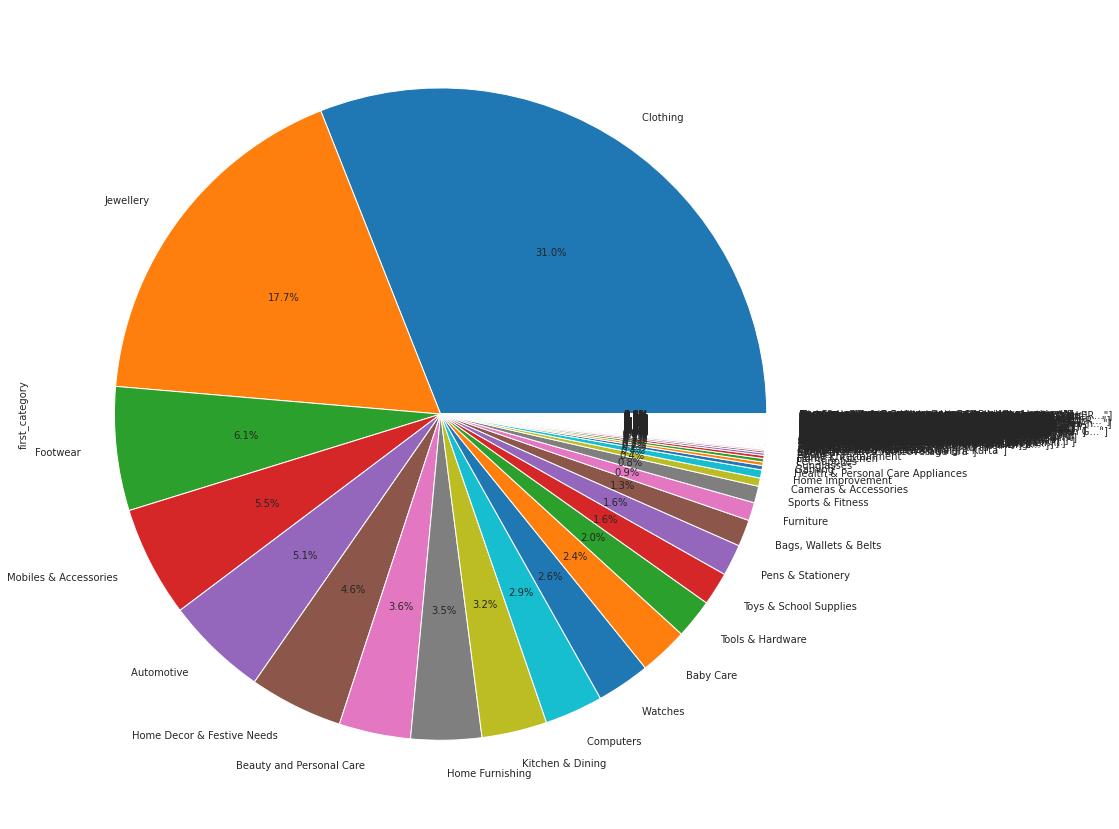

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
flipkart_data['first_category'].value_counts().plot.pie( autopct = '%1.1f%%')

Notice how one category entries are disrupting a peaceful visualization. Let's first check them and find out can they be manually merged. 

In [14]:
flipkart_data.groupby(by='first_category').size().head(20)


first_category
883 Police Full Sleeve Solid Men's Jacket"]              1
ABEEZ Boys, Men, Girls (Black, Pack of 1)"]              1
ANAND ARCHIES Girls Flats"]                              2
ANAND ARCHIES Girls Wedges"]                             1
ANASAZI Casual 3/4 Sleeve Solid Women's Top"]            1
ATV Pouch for Acer Liquid Z330 (STEEL BLUE)"]            1
Abhinl Fashion Cotton Printed Semi-stitched Salw..."]    1
Adidas IND PRO THI GUA Thigh Guard (White, Blue,..."]    1
Ajaero Slim Fit Women's Dark Blue Jeans"]                2
Amita Home Furnishing Cotton Floral Single Bedsh..."]    1
Amita Home Furnishing Cotton Printed Single Beds..."]    1
Anuradha Art Stylish Hair Clip (Black)"]                 1
Anuradha Art Stylish Hair Clip (Blue)"]                  1
Areon Luxurious Fragrance Long Lasting Car,Home,..."]    1
Arial Morris Women Flats"]                               1
Asics Gel-Cumulus 17 Running Shoes"]                     1
Asics Gel-Kayano 22 Running Shoes"]      

Are only 20 entries disrupting us ? If yes, then they can be manually replaced with simpler first_categories that already exist. If not, we will be coerced to drop them instead.

In [15]:
flipkart_data.groupby(by='first_category').size().head(100)



first_category
883 Police Full Sleeve Solid Men's Jacket"]         1
ABEEZ Boys, Men, Girls (Black, Pack of 1)"]         1
ANAND ARCHIES Girls Flats"]                         2
ANAND ARCHIES Girls Wedges"]                        1
ANASAZI Casual 3/4 Sleeve Solid Women's Top"]       1
                                                 ... 
Impala Alloy Cufflink (White)"]                     1
Indistar Self Design Viscose Women's Stole"]        3
JUSF2 Black Color Hair Band (Multicolor)"]          1
Jazz Eyewears Over-sized Sunglasses"]               1
Jewellery                                        3531
Length: 100, dtype: int64

Only 100 ? or more ?

In [16]:
flipkart_data.groupby(by='first_category').size().head(1000)


first_category
883 Police Full Sleeve Solid Men's Jacket"]              1
ABEEZ Boys, Men, Girls (Black, Pack of 1)"]              1
ANAND ARCHIES Girls Flats"]                              2
ANAND ARCHIES Girls Wedges"]                             1
ANASAZI Casual 3/4 Sleeve Solid Women's Top"]            1
                                                        ..
run of luck Solid Women's Round Neck Dark Blue T..."]    1
soie Fashion Women's Full Coverage Bra"]                 1
soie Fashion Women's Sports Bra"]                        1
tadd Men's, Women's Ankle Length Socks"]                 1
xy decor Cotton Sofa Cover (white Pack of 6)"]           1
Length: 266, dtype: int64

Notice that even after top 1000 entries were displayed in order of size, there are still more. It is manually impossible to merge these categories, hence we are coerced to drop them

In [17]:
flipkart_data = flipkart_data[flipkart_data.groupby('first_category')['first_category'].transform('count').ge(5)]


Let's try the pie-chart visualization again

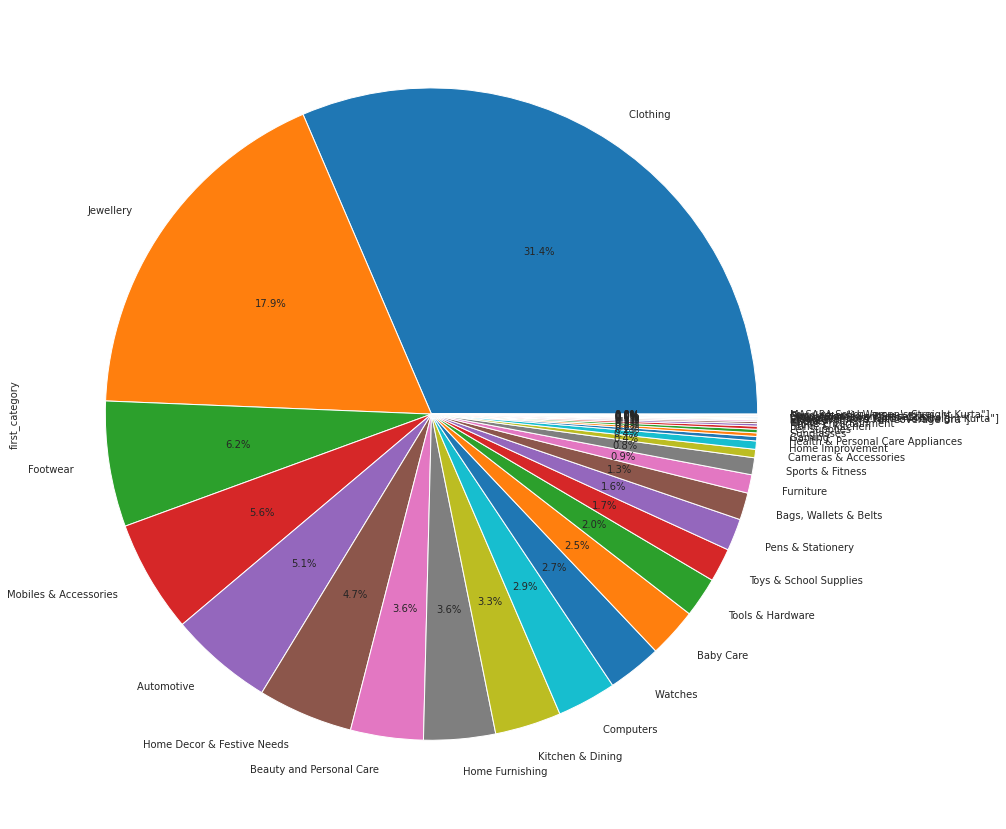

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
flipkart_data['first_category'].value_counts().plot.pie( autopct = '%1.1f%%')

Much better. Let's group them on size basis to see the lowest category frequency.

In [19]:
flipkart_data.groupby(by='first_category').size()


first_category
Automotive                                  1012
Baby Care                                    483
Bags, Wallets & Belts                        265
Beauty and Personal Care                     710
Cameras & Accessories                         82
Clothing                                    6198
Clovia Women's Full Coverage Bra"]             9
Clovia Women's T-Shirt Bra"]                   6
Computers                                    578
Eyewear                                       10
Footwear                                    1227
Furniture                                    180
Gaming                                        35
Health & Personal Care Appliances             43
Home & Kitchen                                24
Home Decor & Festive Needs                   929
Home Entertainment                            19
Home Furnishing                              700
Home Improvement                              81
Jewellery                                   3531
Kitch

**It's perfect. Let's begin finding Wordcloud visualization of description column**

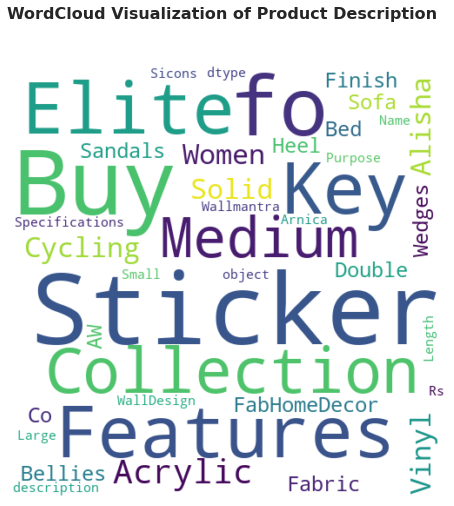

In [20]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS


stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      width=500,
                      height=500
)

wordcloud.generate(str(flipkart_data['description']))
plt.rcParams['figure.figsize'] = (8,8)
plt.axis('off')
plt.suptitle('WordCloud Visualization of Product Description', fontsize=16, fontweight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

Let's move ahead with providing a statistical EDA of training dataset

In [21]:
eda_train = pd.DataFrame()

eda_train['category_len'] = flipkart_data['first_category'].apply(lambda x: len(str(x).split()))
eda_train['description_len'] = flipkart_data['description'].apply(lambda x: len(str(x).split()))

eda_train.describe()

,category_len,description_len
count,19711.000000,19711.000000
mean,1.746385,68.098879
std,1.214641,70.874943
min,1.000000,1.000000
25%,1.000000,31.000000
50%,1.000000,37.000000
75%,3.000000,81.000000
max,5.000000,872.000000


Utilizing the lambda functions we used in the above cell to calculated category and description wordlength, we can now plot the same

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


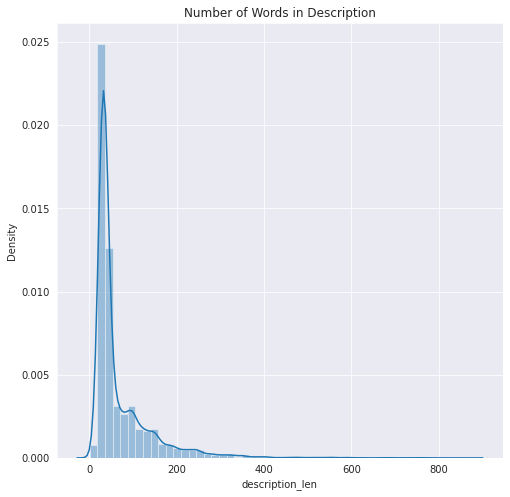

In [22]:
x = eda_train['description_len']
sns.distplot(x)
plt.title('Number of Words in Description')
plt.show()


Let's find the number of words most frequently used for "description" utilizing stats from SciPy and Gaussian KDE on above Distribution Plot

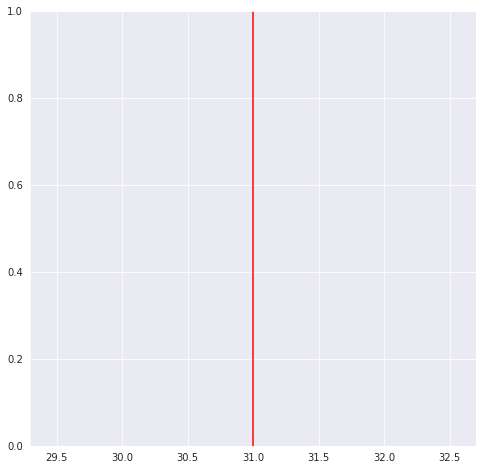

In [23]:
from scipy import stats
kde = stats.gaussian_kde(x) # Compute the Gaussian KDE
idx = np.argmax(kde.pdf(x)) # Get index of peak point
plt.axvline(x[idx], color='red') 

**Average number of words used by seller for description of a product is 31**

With this we finish visualization of our training dataset. The choice for our visualization was to gather useful insight and not just for the purposing of doing so. Further, this point no visualization would be possible. We shall now move ahead to pre-processing and training ML algorithms for our purpose.

## Subtask 2(B) Pre-processing Training Dataset

This would involve the following steps - 

1. Identification of (if any) null values
2. Training & Testing dataset split (70:30)
3. Stopword removal from Description Column
4. Tf-IDF vectorization with Pipeline formation (along with LinearSVC)

We begin with checking if there are any null values in the column

In [24]:
flipkart_data.isnull().sum()

description       2
first_category    0
dtype: int64

Yes. There are two categories with no description. We drop them

In [25]:
data = flipkart_data.dropna()

In [26]:
len(data)

19709

As we mentioned in the task, the primary "product description" must be the input feature, we create X and y training datasets respectively.

In [27]:
#Using 'description' as the only feature for training

X = data['description']
y = data['first_category']

We perform the Training & Testing dataset split (70:30)

In [28]:
#Preparing Training Data and perform train-test split

# Split the data into 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77, shuffle=True, stratify = y)

#Checking the shape of the splitted data
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (13796,)
Testing Data Shape: (5913,)


Moving ahead to Stopword collection and removal via NLTK library

In [29]:
# Create list of StopWords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Finally, we perform Tfidf vectorization with stopwords and add the same to the pipeline

In [30]:
from sklearn.svm import LinearSVC
linear_svc = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                           ('clf', LinearSVC())])



## Subtask 3: Identidication of Accuracy Metrics

We shall use the following metrics to measure accuracy of our classifier models

1. Weighted Precision
2. Weighted Recall
3. Accuracy
4. F1 score
5. Confusion Matrix

## Subtask 4. Trying various ML Classification Algorithms

We shall try the following ML classification algorithms in order - 

1. Linear Support Vector Machine
2. Naive Bayes
3. KNN
4. Random Forest

In [31]:
linear_svc.fit(X_train, y_train)
predictions = linear_svc.predict(X_test)
# Print the overall accuracy, along with weighted precision, weighted recall and f1 scores
print("Accuracy by LinearSVC is ")
print(metrics.accuracy_score(y_test,predictions)*100)
print("Weighted Precision by LinearSVC is")
print(metrics.precision_score(y_test,predictions, average='weighted')*100)
print("Weighted Recall by LinearSVC is ")
print(metrics.recall_score(y_test,predictions, average='weighted')*100)
print("F1 score by LinearSVC is ")
print(metrics.f1_score(y_test,predictions, average='weighted')*100)

Accuracy by LinearSVC is 
97.78454253340098
Weighted Precision by LinearSVC is
97.70037710659703
Weighted Recall by LinearSVC is 
97.78454253340098
F1 score by LinearSVC is 
97.69830289578353


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))
# Print a classification report
print(metrics.classification_report(y_test,predictions))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

[[302   0   0 ...   0   0   0]
 [  0 126   0 ...   0   0   0]
 [  0   0  75 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0 157   0]
 [  0   0   0 ...   0   0   1]]
                                          precision    recall  f1-score   support

                             Automotive        0.98      0.99      0.99       304
                              Baby Care        0.95      0.87      0.91       145
                  Bags, Wallets & Belts        0.91      0.94      0.93        80
               Beauty and Personal Care        0.97      0.97      0.97       213
                  Cameras & Accessories        0.96      0.96      0.96        25
                               Clothing        0.99      1.00      0.99      1859
      Clovia Women's Full Coverage Bra"]       0.00      0.00      0.00         3
            Clovia Women's T-Shirt Bra"]       0.00      0.00      0.00         2
                              Computers        0.95      0.97      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Bayes

In [33]:
naive_bayes = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                     ('clf', MultinomialNB())])

naive_bayes.fit(X_train, y_train) 

predictions = naive_bayes.predict(X_test)
# Print the overall accuracy, along with weighted precision, weighted recall and f1 scores
print("Accuracy by Naive Bayes is ")
print(metrics.accuracy_score(y_test,predictions)*100)
print("Weighted Precision by Naive Bayes is")
print(metrics.precision_score(y_test,predictions, average='weighted')*100)
print("Weighted Recall by Naive Bayes is ")
print(metrics.recall_score(y_test,predictions, average='weighted')*100)
print("F1 score by Naive Bayes is ")
print(metrics.f1_score(y_test,predictions, average='weighted')*100)

Accuracy by Naive Bayes is 
82.1917808219178
Weighted Precision by Naive Bayes is
83.19448969740401
Weighted Recall by Naive Bayes is 
82.1917808219178
F1 score by Naive Bayes is 
78.9909201305667


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))
# Print a classification report
print(metrics.classification_report(y_test,predictions))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

[[288   0   0 ...   0   0   0]
 [  0  57   0 ...   0   0   0]
 [  0   0   5 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 144   0]
 [  0   0   0 ...   0   0   0]]
                                          precision    recall  f1-score   support

                             Automotive        0.94      0.95      0.94       304
                              Baby Care        0.97      0.39      0.56       145
                  Bags, Wallets & Belts        1.00      0.06      0.12        80
               Beauty and Personal Care        1.00      0.43      0.60       213
                  Cameras & Accessories        0.00      0.00      0.00        25
                               Clothing        0.81      1.00      0.89      1859
      Clovia Women's Full Coverage Bra"]       0.00      0.00      0.00         3
            Clovia Women's T-Shirt Bra"]       0.00      0.00      0.00         2
                              Computers        0.98      0.60      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [35]:
knn_classifier = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                     ('clf', KNeighborsClassifier())])

knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
# Print the overall accuracy, along with weighted precision, weighted recall and f1 scores
print("Accuracy by KNN Classifier is ")
print(metrics.accuracy_score(y_test,predictions)*100)
print("Weighted Precision by KNN Classifier is")
print(metrics.precision_score(y_test,predictions, average='weighted')*100)
print("Weighted Recall by KNN Classifier is ")
print(metrics.recall_score(y_test,predictions, average='weighted')*100)
print("F1 score by KNN Classifier is ")
print(metrics.f1_score(y_test,predictions, average='weighted')*100)

Accuracy by KNN Classifier is 
95.16319972940977
Weighted Precision by KNN Classifier is
95.09661665518692
Weighted Recall by KNN Classifier is 
95.16319972940977
F1 score by KNN Classifier is 
95.06287355807623


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))
# Print a classification report
print(metrics.classification_report(y_test,predictions))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

[[299   0   0 ...   0   0   0]
 [  0 112   0 ...   0   0   0]
 [  0   0  76 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0 152   0]
 [  0   0   0 ...   0   0   2]]
                                          precision    recall  f1-score   support

                             Automotive        0.92      0.98      0.95       304
                              Baby Care        0.84      0.77      0.80       145
                  Bags, Wallets & Belts        0.87      0.95      0.91        80
               Beauty and Personal Care        0.89      0.92      0.90       213
                  Cameras & Accessories        1.00      0.96      0.98        25
                               Clothing        0.97      0.99      0.98      1859
      Clovia Women's Full Coverage Bra"]       0.00      0.00      0.00         3
            Clovia Women's T-Shirt Bra"]       0.00      0.00      0.00         2
                              Computers        0.93      0.94      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [37]:
random_forest = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                     ('clf', RandomForestClassifier())])

random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
# Print the overall accuracy, along with weighted precision, weighted recall and f1 scores
print("Accuracy by Random Forest is ")
print(metrics.accuracy_score(y_test,predictions)*100)
print("Weighted Precision by Random Forest is")
print(metrics.precision_score(y_test,predictions, average='weighted')*100)
print("Weighted Recall by Random Forest is ")
print(metrics.recall_score(y_test,predictions, average='weighted')*100)
print("F1 score by Random Forest is ")
print(metrics.f1_score(y_test,predictions, average='weighted')*100)

Accuracy by Random Forest is 
94.97716894977168
Weighted Precision by Random Forest is
94.8277969161381
Weighted Recall by Random Forest is 
94.97716894977168
F1 score by Random Forest is 
94.65536611683517


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))
# Print a classification report
print(metrics.classification_report(y_test,predictions))
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

[[298   0   0 ...   0   0   0]
 [  1  93   0 ...   0   0   0]
 [  1   0  62 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0 157   0]
 [  0   0   0 ...   0   0   0]]
                                          precision    recall  f1-score   support

                             Automotive        0.97      0.98      0.98       304
                              Baby Care        0.96      0.64      0.77       145
                  Bags, Wallets & Belts        0.93      0.78      0.84        80
               Beauty and Personal Care        0.97      0.91      0.94       213
                  Cameras & Accessories        1.00      0.80      0.89        25
                               Clothing        0.96      1.00      0.98      1859
      Clovia Women's Full Coverage Bra"]       0.00      0.00      0.00         3
            Clovia Women's T-Shirt Bra"]       0.00      0.00      0.00         2
                              Computers        0.86      0.85      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Of all the four ML classifiers we used, Linear Support Vectorm Machine gave the highest accuracy of 97.78% 

###However, we must be vary that it might be a result of overfitting that might yield such high accuracy results. For the purpose of same, we perform the following one simple step for our confirmation - 

1. Calculation of K-fold Cross Validation with k=5 

In [39]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(linear_svc,X, y, cv=5)
print("Accuracy = %0.3f with either plus/minus %0.3f" %(scores.mean(), scores.std()*3))

Accuracy = 0.948 with either plus/minus 0.028


While the difference between the cross-validation accuracy and raw accuracy is around 2.98% which while is significant doesn't cause concern for overfitting. 
Besides, Linear Support Vector Machines, on an average, perform better than most of the ML classifiers in tasks of "Text Classification" and "Document Classification"

## Subtask 5. Identification of strategies that might improve the accuracy further

The following strategies might improve the accuracy further - 
1. Pre-processing with Word2Vec and utilizing Logistic Regression
2. Pre-processing with Doc2Vect and utilizing Logistic Regression
3. Pre-processing with Bag-of-Words and utilizing Keras


## Thank You.